# Pylops - Marchenko redatuming by iterative substitutions

Let's consider the Marchenko equations:

$$
\mathbf{f^-}  =  \Theta \mathbf{R} \mathbf{f_d^+} + \Theta \mathbf{R} \mathbf{f_m^+} \\
\mathbf{f_m^+} = \Theta \mathbf{R^*} \mathbf{f^-}
$$

where $\Theta = \Theta^{-t_d+\epsilon}_{t_d-\epsilon}$.

One way of solving those equations is by rearranging them into a matrix-vector form and apply **direct inversion** (via e.g., LSQR):

$$
        \begin{bmatrix}
           \Theta \mathbf{R} \mathbf{f_d^+}  \\
           \mathbf{0}
        \end{bmatrix} =
        \mathbf{I} -
        \begin{bmatrix}
           \mathbf{0}  &   \Theta \mathbf{R}   \\
           \Theta \mathbf{R^*} & \mathbf{0}
        \end{bmatrix}
        \begin{bmatrix}
           \mathbf{f^-}  \\
           \mathbf{f_m^+}
        \end{bmatrix}
$$

Alternatively, we can solve the two original equations by **iterative substitution**. This is equivalent to first plugging $\mathbf{f^-}$ in the first equation:

$$
\mathbf{f_m^+} =  \Theta \mathbf{R^*} (\Theta \mathbf{R} \mathbf{f_d^+} + \Theta \mathbf{R} \mathbf{f_m^+})
$$

and isolating $\mathbf{f_m^+}$:

$$
(\mathbf{I} - \Theta \mathbf{R^*}\Theta \mathbf{R}) \mathbf{f_m^+} =  \Theta \mathbf{R^*} \Theta \mathbf{R} \mathbf{f_d^+}
$$

We can then expand the term within parenthesis as a Neumann series and write:

$$
\mathbf{f^+} = \sum_{k=0}^\inf (\Theta \mathbf{R^*}\Theta \mathbf{R})^k \mathbf{f_d^+}
$$

### Author: M.Ravasi

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import cg, lsqr
from scipy.signal import convolve, filtfilt

from pylops                            import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.waveeqprocessing.marchenko import *
from pylops.optimization.leastsquares  import *

from pymarchenko.neumarchenko import NeumannMarchenko

## Inputs

Input parameters 

In [2]:
inputfile = '../testdata/marchenko/input.npz' # choose file in testdata folder of repo

vel = 2400.0        # velocity
toff = 0.045        # direct arrival time shift
nsmooth = 10        # time window smoothing 
nfmax = 500         # max frequency for MDC (#samples)
nstaper = 11        # source/receiver taper lenght
n_iter = 10         # iterations

jr = 1              # subsampling in r
js = 1              # subsampling in s

Load input

In [3]:
inputdata = np.load(inputfile)

Read and visualize geometry

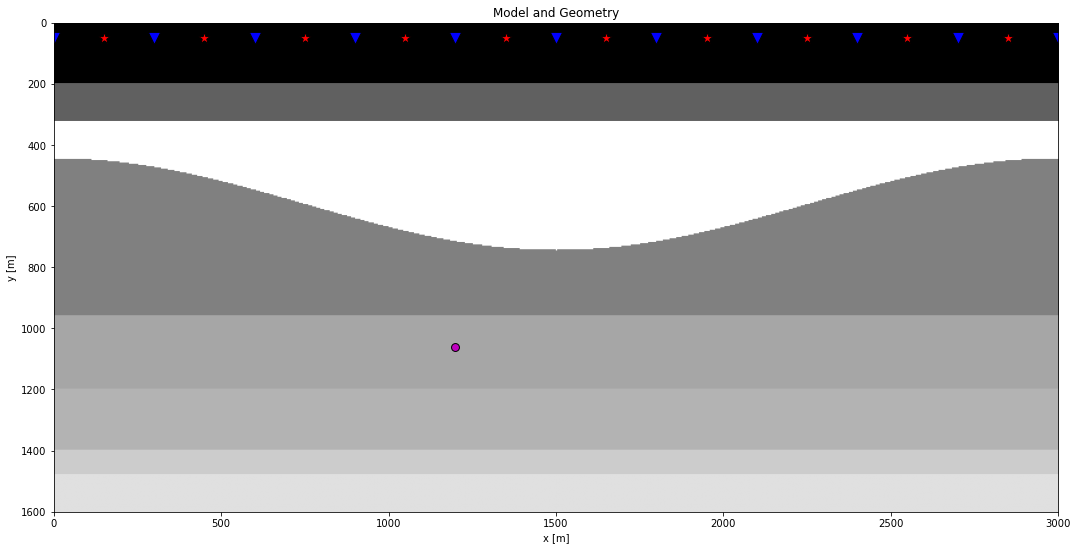

In [4]:
# Receivers
r = inputdata['r'][:,::jr]
nr = r.shape[1]
dr = r[0,1]-r[0,0]

# Sources
s = inputdata['s'][:,::js]
ns = s.shape[1]
ds = s[0,1]-s[0,0]

# Virtual points
vs = inputdata['vs']

# Density model
rho = inputdata['rho']
z, x = inputdata['z'], inputdata['x']

plt.figure(figsize=(18,9))
plt.imshow(rho, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(s[0, 5::10], s[1, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(r[0, ::10],  r[1, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(vs[0], vs[1], marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1]);

Read data

In [5]:
# time axis
t = inputdata['t']
ot, dt, nt = t[0], t[1]-t[0], len(t)
t2 = np.concatenate([-np.flipud(t), t[1:]])

# data
R = inputdata['R'][::js, ::jr]
R = np.swapaxes(R, 0, 1) # R[r, s, f] (for data with dipole source, you need to integrate over sources)

# tapering
taper = taper3d(nt, [ns, nr], [nstaper, nstaper], tapertype='hanning')
R = R*taper

Read subsurface fields and wavelet to apply to subsurface fields

In [6]:
Gsub = inputdata['Gsub'][:, ::jr]
G0sub = inputdata['G0sub'][:, ::jr]
wav = inputdata['wav']
wav_c = np.argmax(wav)

# convolve with wavelet
Gsub = np.apply_along_axis(convolve, 0, Gsub, wav, mode='full')
Gsub = Gsub[wav_c:][:nt]
G0sub = np.apply_along_axis(convolve, 0, G0sub, wav, mode='full') 
G0sub = G0sub[wav_c:][:nt]

In [7]:
print(R.max())
print(G0sub.max())

0.3754
2577738.4579874733


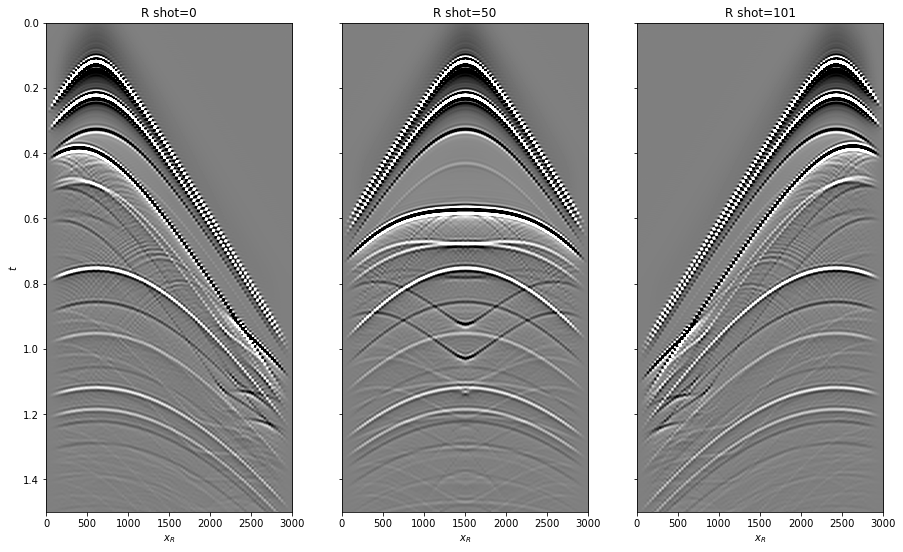

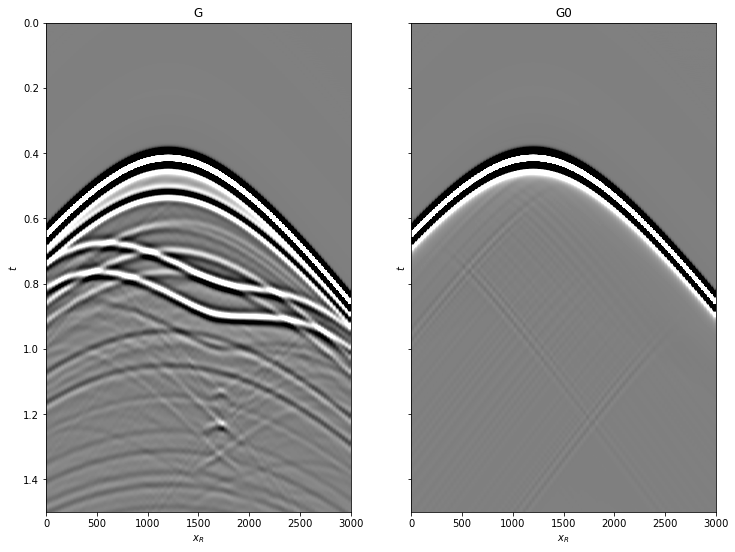

In [8]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 9))
axs[0].imshow(R[20].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('R shot=0'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0)
axs[1].imshow(R[ns//2].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('R shot=%d' %(ns//2)), axs[1].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0)
axs[2].imshow(R[-20].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[2].set_title('R shot=%d' %ns), axs[2].set_xlabel(r'$x_R$')
axs[2].axis('tight');
axs[2].set_ylim(1.5, 0)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 9))
axs[0].imshow(Gsub, cmap='gray', vmin=-1e5, vmax=1e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('G'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0)
axs[1].imshow(G0sub, cmap='gray', vmin=-1e5, vmax=1e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('G0'), axs[1].set_xlabel(r'$x_R$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0);

## Marchenko preparation

Create window

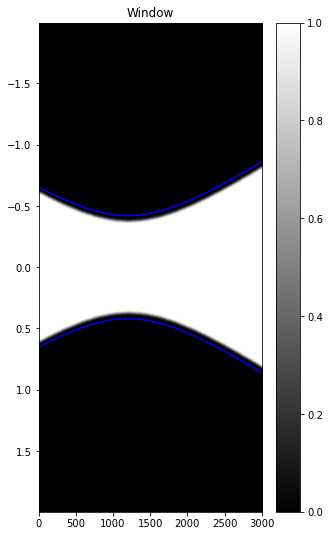

In [9]:
# direct arrival window - traveltime
directVS = np.sqrt((vs[0]-r[0])**2+(vs[1]-r[1])**2)/vel
directVS_off = directVS - toff

# window
idirectVS_off = np.round(directVS_off/dt).astype(np.int)
w = np.zeros((nr, nt))
for ir in range(nr):
    w[ir, :idirectVS_off[ir]]=1            
w = np.hstack((np.fliplr(w), w[:, 1:]))

if nsmooth>0:
    smooth=np.ones(nsmooth)/nsmooth
    w  = filtfilt(smooth, 1, w)    
    
fig, ax = plt.subplots(1, 1,  sharey=True, figsize=(5, 9))
im = ax.imshow(w.T, cmap='gray', extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax.plot(r[0], directVS,'b'),ax.plot(r[0], -directVS,'b')
ax.set_title('Window'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
ax.axis('tight')
fig.colorbar(im, ax=ax);

## Inversion

In [10]:
# Add negative time to operators
Rtwosided = np.concatenate((np.zeros((nr, ns, nt-1)), R), axis=-1)
Rtwosided_fft = np.fft.rfft(Rtwosided, 2*nt-1, axis=-1) / np.sqrt(2*nt-1)
Rtwosided_fft = Rtwosided_fft[...,:nfmax]
Rtwosided_fft = Rtwosided_fft.transpose(2, 0, 1) # R[f, r, s]

# Operators
Rop = MDC(Rtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, transpose=False, dtype='complex64')
R1op = MDC(Rtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, transpose=False, 
           conj=True, dtype='complex64')
Rollop = Roll((2*nt-1) * nr,
              dims=(2*nt-1, nr),
              dir=0, shift=-1)

# Input focusing function
fd_plus =  np.concatenate((np.fliplr(G0sub.T).T, np.zeros((nt-1, nr))))

Create Marchenko operator

In [11]:
Wop = Diagonal(w.T.flatten())
Iop = Identity(nr*(2*nt-1))

Mop = VStack([HStack([Iop, -1*Wop*Rop]),
              HStack([-1*Wop*Rollop*R1op, Iop])])*BlockDiag([Wop, Wop])
Gop = VStack([HStack([Iop, -1*Rop]),
              HStack([-1*Rollop*R1op, Iop])])

dottest(Gop, 2*nr*(2*nt-1), 2*nr*(2*nt-1), verb=True)
dottest(Mop, 2*nr*(2*nt-1), 2*nr*(2*nt-1), verb=True);

Dot test passed, v^T(Opu)=517.955527 - u^T(Op^Tv)=517.955527
Dot test passed, v^T(Opu)=62.605435 - u^T(Op^Tv)=62.605435


Run standard redatuming as benchmark

In [12]:
p0_minus = Rop * fd_plus.flatten()
p0_minus = p0_minus.reshape((2*nt-1), nr).T

Create data, adjoint and inverse focusing functions

In [13]:
d = Wop*Rop*fd_plus.flatten()
d = np.concatenate((d.reshape(2*nt-1, nr), np.zeros((2*nt-1, nr))))

f1_adj = Mop.H*d.flatten()
f1_inv = lsqr(Mop, d.flatten(), iter_lim=n_iter, show=True)[0]

f1_adj = f1_adj.reshape(2*(2*nt-1), nr)
f1_inv = f1_inv.reshape(2*(2*nt-1), nr)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 322998 rows and 322998 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.983e+07  2.983e+07    1.0e+00  3.5e-08
     1  0.00000e+00   1.311e+07  1.311e+07    4.4e-01  9.2e-01   1.1e+00  1.0e+00
     2  0.00000e+00   7.406e+06  7.406e+06    2.5e-01  3.9e-01   1.8e+00  2.2e+00
     3  0.00000e+00   5.479e+06  5.479e+06    1.8e-01  3.3e-01   2.1e+00  3.4e+00
     4  0.00000e+00   3.659e+06  3.659e+06    1.2e-01  3.3e-01   2.5e+00  5.2e+00
     5  0.00000e+00   2.780e+06  2.780e+06    9.3e-02  2.6e-01   2.9e+00  6.8e+00
     6  0.00000e+00   2.244e+06  2.244e+06    7.5e-02  2.3e-01   3.2e+00  8.5e+00
     7  0.00000e+00   1.498e+06  1.498e+06    5.0e-02  2.5e-01   3.6e+00  1.1e+01
     8  0.00000e+00   1.105e+0

Add initial guess to estimated focusing functions

In [14]:
f1_adj_tot = f1_adj + np.concatenate((np.zeros((2*nt-1, nr)),
                                      np.concatenate((np.fliplr(G0sub.T).T, 
                                                      np.zeros((nt-1, nr))), axis=0)))

f1_inv_tot = f1_inv + np.concatenate((np.zeros((2*nt-1, nr)),
                                      fd_plus))

Estimate Green's functions

In [15]:
g_adj = Gop*f1_adj_tot.flatten()
g_inv = Gop*f1_inv_tot.flatten()

g_adj = g_adj.reshape(2*(2*nt-1), nr)
g_inv = g_inv.reshape(2*(2*nt-1), nr)

Extract up and down focusing and Green's functions from model vectors

In [16]:
f1_adj_minus, f1_adj_plus =  f1_adj_tot[:(2*nt-1)].T, f1_adj_tot[(2*nt-1):].T
f1_inv_minus, f1_inv_plus =  f1_inv_tot[:(2*nt-1)].T, f1_inv_tot[(2*nt-1):].T

g_adj_minus, g_adj_plus =  -g_adj[:(2*nt-1)].T, np.fliplr(g_adj[(2*nt-1):].T)
g_inv_minus, g_inv_plus =  -g_inv[:(2*nt-1)].T, np.fliplr(g_inv[(2*nt-1):].T)

g_inv_tot = g_inv_minus + g_inv_plus

## Iterative substitution

In [17]:
# Add negative time to operators
Rtwosided = np.concatenate((np.zeros((nr, ns, nt-1)), R), axis=-1)
Rtwosided_fft = np.fft.rfft(Rtwosided, 2*nt-1, axis=-1) / np.sqrt(2*nt-1)
Rtwosided_fft = Rtwosided_fft[...,:nfmax]
Rtwosided_fft = Rtwosided_fft.transpose(2, 0, 1) # R[f, r, s]

# Operators
Rop = MDC(Rtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, transpose=False, dtype='complex64')
R1op = MDC(Rtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, transpose=False, 
           conj=True, dtype='complex64')
Rollop = Roll((2*nt-1) * nr,
              dims=(2*nt-1, nr),
              dir=0, shift=-1)

# Input focusing function
fd_plus =  np.concatenate((np.fliplr(G0sub.T).T, np.zeros((nt-1, nr))))

In [18]:
f1_sub_plus = fd_plus.copy()
f1_sub_plus_updates = np.zeros((n_iter, 2*nt -1, nr))
f1_sub_plus_updates[0] = fd_plus.copy()

for i_iter in range(n_iter-1):
    f1_sub_plus = (Wop * Rollop * R1op * Wop * Rop) * f1_sub_plus.ravel()
    f1_sub_plus = f1_sub_plus.reshape(2*nt-1, nr)
    f1_sub_plus_updates[i_iter+1] = f1_sub_plus.copy()

f1_sub_plus = np.sum(f1_sub_plus_updates, axis=0)  
f1_sub_minus = Wop * Rop * f1_sub_plus.ravel()
g_sub_minus = - (f1_sub_minus.ravel() - Rop * f1_sub_plus.ravel())
g_sub_plus = f1_sub_plus.ravel() - Rollop * R1op * f1_sub_minus.ravel()

f1_sub_minus = f1_sub_minus.reshape(2*nt-1, nr)
g_sub_minus = g_sub_minus.reshape(2*nt-1, nr)
g_sub_plus = np.flipud(g_sub_plus.reshape(2*nt-1, nr))

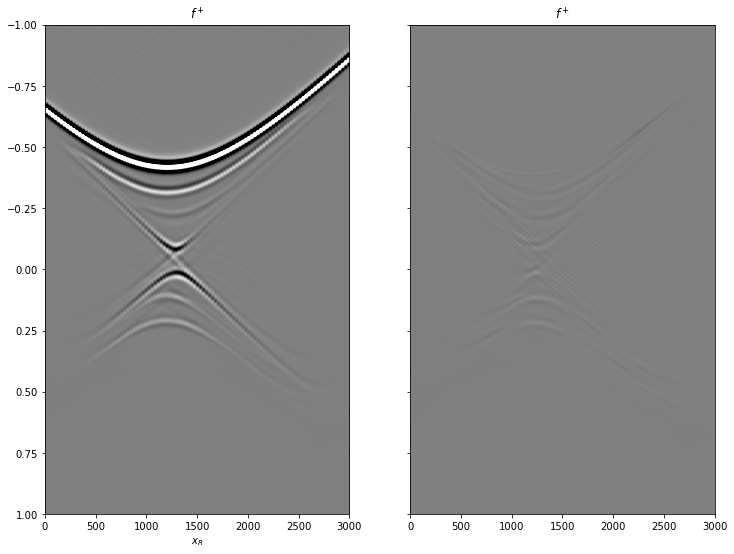

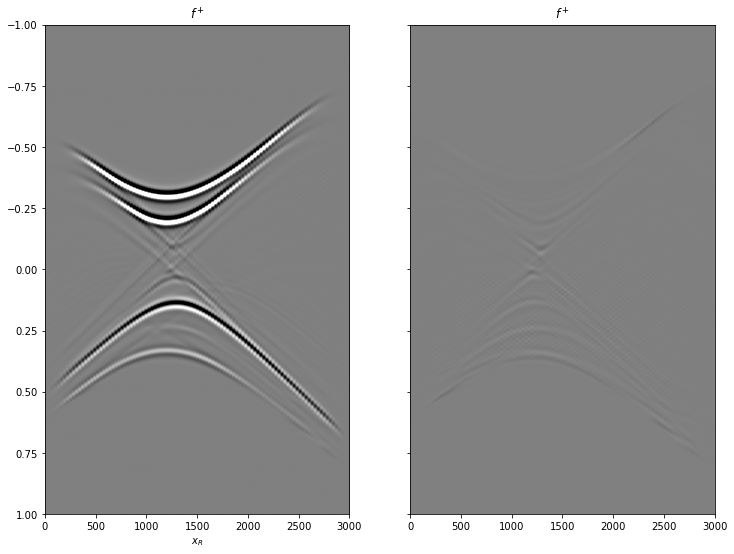

In [19]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 9))
axs[0].imshow(f1_inv_plus.T, cmap='gray', vmin=-5e5, vmax=5e5, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1)
axs[1].imshow(f1_inv_plus.T - f1_sub_plus, cmap='gray', vmin=-5e5, vmax=5e5, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 9))
axs[0].imshow(f1_inv_minus.T, cmap='gray', vmin=-5e5, vmax=5e5, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1)
axs[1].imshow(f1_inv_minus.T - f1_sub_minus, cmap='gray', vmin=-5e5, vmax=5e5, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);

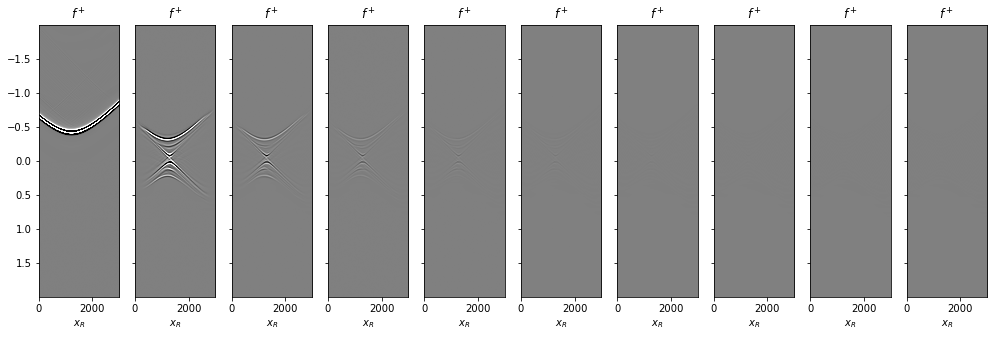

In [20]:
fig, axs = plt.subplots(1, n_iter, sharey=True, figsize=(17, 5))
for iiter in range(n_iter):
    axs[iiter].imshow(f1_sub_plus_updates[iiter], cmap='gray', vmin=-1e5, vmax=1e5, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
    axs[iiter].set_title(r'$f^+$')
    axs[iiter].set_xlabel(r'$x_R$')
    axs[iiter].axis('tight')

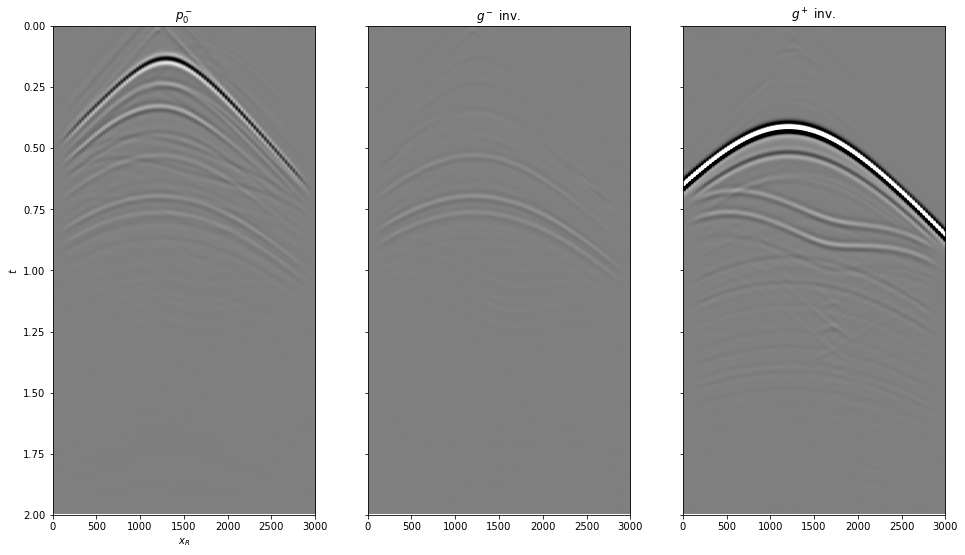

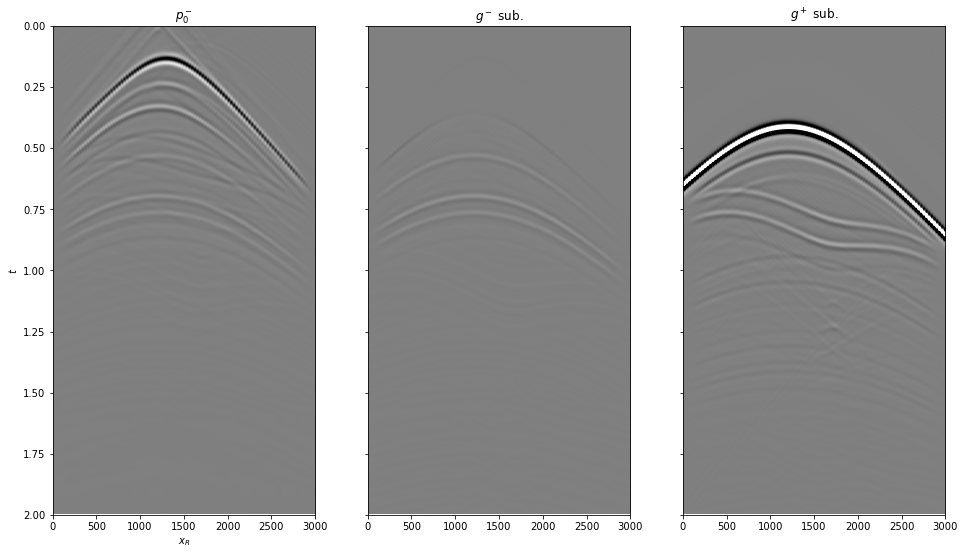

In [21]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_minus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2, 0);
axs[1].imshow(g_inv_minus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$g^-$ inv.'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2, 0);
axs[2].imshow(g_inv_plus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$g^+$ inv.'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(2, 0);

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_minus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2, 0);
axs[1].imshow(g_sub_minus, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$g^-$ sub.'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2, 0);
axs[2].imshow(g_sub_plus, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$g^+$ sub.'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(2, 0);

Use function

In [22]:
def applyiterative_onepoint(R, trav, G0, dt, nfmax, n_iter=10, toff=0.01, nsmooth=5):
    nt, nr = G0.shape
    
    # Create window
    trav_off = trav - toff
    trav_off = np.round(trav_off / dt).astype(np.int)

    w = np.zeros((nr, nt))
    for ir in range(nr):
        w[ir, :trav_off[ir]] = 1
    w = np.hstack((np.fliplr(w), w[:, 1:]))
    if nsmooth > 0:
        smooth = np.ones(nsmooth) / nsmooth
        w = filtfilt(smooth, 1, w)
    
    # Add negative time to operators
    Rtwosided = np.concatenate((np.zeros((nr, ns, nt-1)), R), axis=-1)
    Rtwosided_fft = np.fft.rfft(Rtwosided, 2*nt-1, axis=-1) / np.sqrt(2*nt-1)
    Rtwosided_fft = Rtwosided_fft[...,:nfmax]
    Rtwosided_fft = Rtwosided_fft.transpose(2, 0, 1) # R[f, r, s]

    # Operators
    Rop = MDC(Rtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, transpose=False, dtype='complex64')
    R1op = MDC(Rtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, transpose=False, 
               conj=True, dtype='complex64')
    Rollop = Roll((2*nt-1) * nr,
                  dims=(2*nt-1, nr),
                  dir=0, shift=-1)

    Wop = Diagonal(w.T.flatten())
    Iop = Identity(nr*(2*nt-1))

    Mop = VStack([HStack([Iop, -1*Wop*Rop]),
                  HStack([-1*Wop*Rollop*R1op, Iop])])*BlockDiag([Wop, Wop])
    Gop = VStack([HStack([Iop, -1*Rop]),
                  HStack([-1*Rollop*R1op, Iop])])

    # Iterations for f1_plus
    f1_sub_plus =  np.concatenate((np.flip(G0, axis=0), np.zeros((nt-1, nr))))

    #f1_sub_plus = fd_plus.copy()
    f1_sub_plus_updates = np.zeros((n_iter, 2*nt -1, nr))
    f1_sub_plus_updates[0] = fd_plus.copy()

    for i_iter in range(n_iter-1):
        f1_sub_plus = (Wop * Rollop * R1op * Wop * Rop) * f1_sub_plus.ravel()
        f1_sub_plus = f1_sub_plus.reshape(2*nt-1, nr)
        f1_sub_plus_updates[i_iter+1] = f1_sub_plus.copy()

    f1_sub_plus = np.sum(f1_sub_plus_updates, axis=0)  
    f1_sub_minus = Wop * Rop * f1_sub_plus.ravel()
    g_sub_minus = - (f1_sub_minus.ravel() - Rop * f1_sub_plus.ravel())
    g_sub_plus = f1_sub_plus.ravel() - Rollop * R1op * f1_sub_minus.ravel()

    f1_sub_minus = f1_sub_minus.reshape(2*nt-1, nr)
    g_sub_minus = g_sub_minus.reshape(2*nt-1, nr)
    g_sub_plus = np.flipud(g_sub_plus.reshape(2*nt-1, nr))

    return f1_sub_plus, f1_sub_minus, g_sub_minus, g_sub_plus, f1_sub_plus_updates

In [23]:
f1_plus_f, f1_minus_f, g_minus_f, g_plus_f, f1_plus_updates_f = \
    applyiterative_onepoint(R, directVS, G0=G0sub, dt=dt, nfmax=nfmax, n_iter=10, toff=toff, nsmooth=nsmooth)

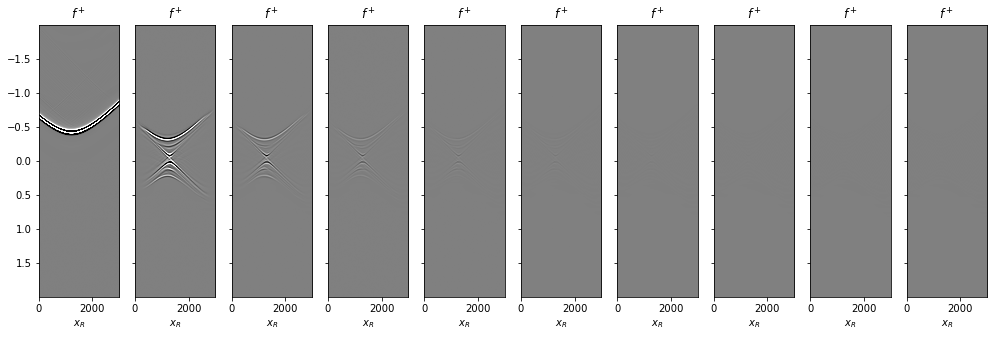

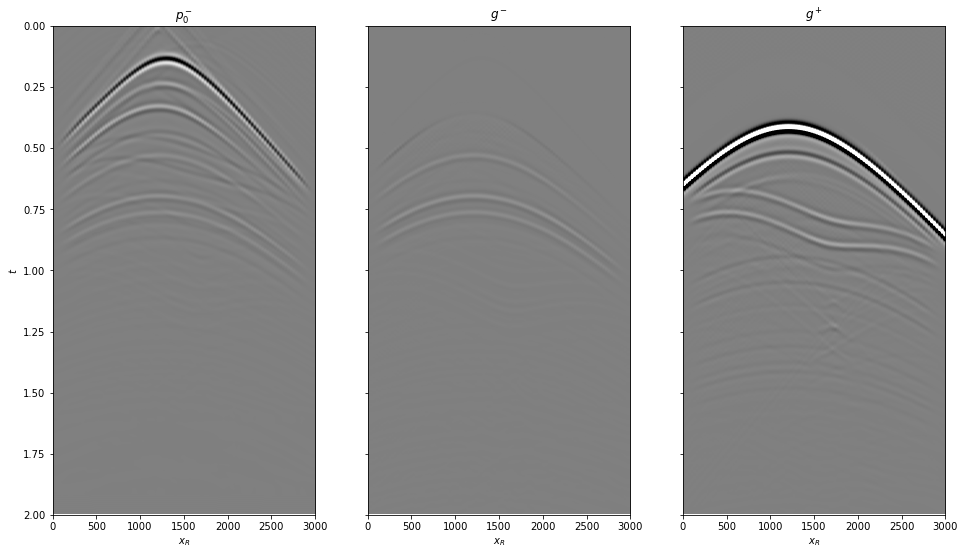

In [24]:
fig, axs = plt.subplots(1, n_iter, sharey=True, figsize=(17, 5))
for iiter in range(n_iter):
    axs[iiter].imshow(f1_plus_updates_f[iiter], cmap='gray', vmin=-1e5, vmax=1e5, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
    axs[iiter].set_title(r'$f^+$')
    axs[iiter].set_xlabel(r'$x_R$')
    axs[iiter].axis('tight')
    
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_minus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2, 0);
axs[1].imshow(g_minus_f, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$g^-$'), axs[1].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2, 0);
axs[2].imshow(g_plus_f, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$g^+$'), axs[2].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(2, 0);

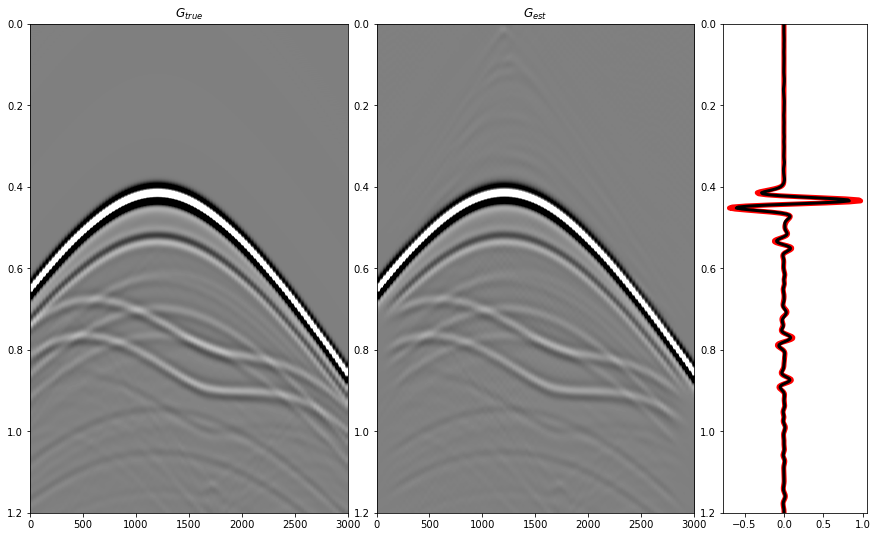

In [25]:
fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(Gsub, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax1.set_title(r'$G_{true}$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
ax1.axis('tight')
ax1.set_ylim(1.2, 0)
ax2.imshow(g_inv_tot.T, cmap='gray', vmin=-5e5, vmax=5e5, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax2.set_title(r'$G_{est}$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
ax2.axis('tight')
ax2.set_ylim(1.2, 0)

ax3.plot(Gsub[:, nr//2]/Gsub.max(), t, 'r', lw=5)
ax3.plot(g_inv_tot[nr//2, nt-1:]/g_inv_tot.max(), t, 'k', lw=3)
ax3.set_ylim(1.2, 0);

## Examples of Marchenko class usage for single virtual point

In [26]:
Rtwosided = np.concatenate((R, np.zeros((nr, ns, nt-1))), axis=-1)
Rtwosided_fft = np.fft.rfft(Rtwosided, 2*nt-1, axis=-1)/np.sqrt(2*nt-1)
Rtwosided_fft = Rtwosided_fft[...,:nfmax]

In [27]:
MarchenkoWM = NeumannMarchenko(Rtwosided_fft, nt=nt, dt=dt, dr=dr, 
                               nfmax=nfmax, wav=wav, toff=toff, nsmooth=nsmooth)

#MarchenkoWM = NeumannMarchenko(R, nt=nt, dt=dt, dr=dr, 
#                               nfmax=nfmax, wav=wav, toff=toff, nsmooth=nsmooth)

f1_minus_f1, f1_plus_f1, p0_minus_f1, g_minus_f1, g_plus_f1 = \
    MarchenkoWM.apply_onepoint(directVS, G0=G0sub.T, rtm=True, greens=True, n_iter=n_iter)
g_tot_f1 = g_minus_f1 + g_plus_f1

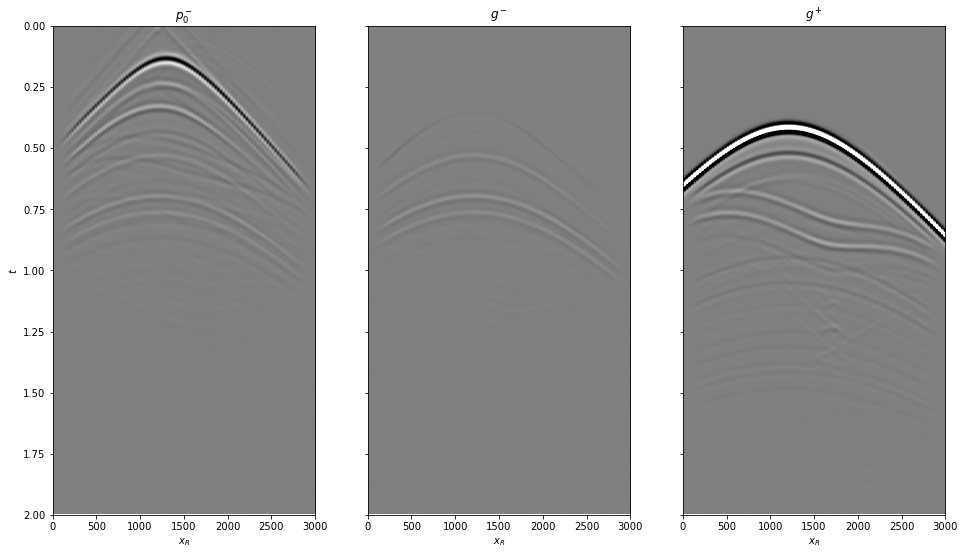

In [28]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_minus_f1.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2, 0);
axs[1].imshow(g_minus_f1.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$g^-$'), axs[1].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2, 0);
axs[2].imshow(g_plus_f1.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$g^+$'), axs[2].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(2, 0);

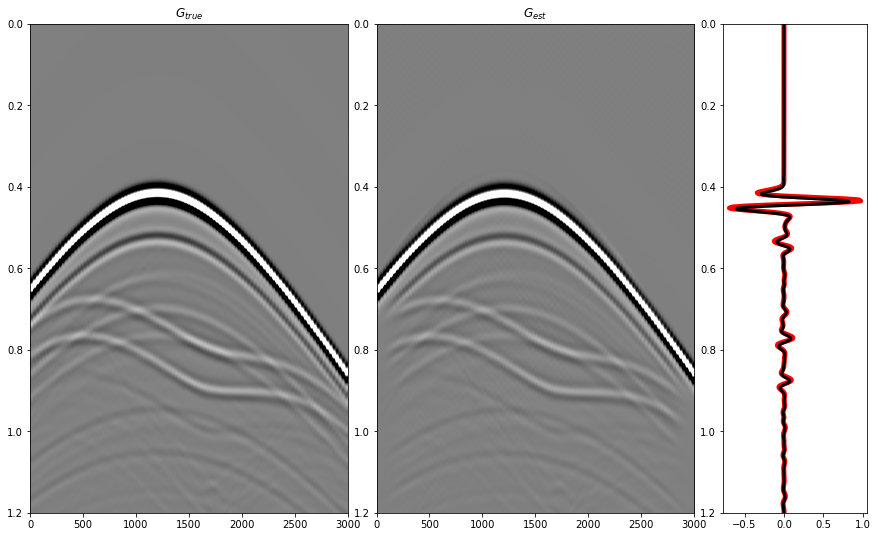

In [29]:
fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(Gsub, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax1.set_title(r'$G_{true}$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
ax1.axis('tight')
ax1.set_ylim(1.2, 0)
ax2.imshow(g_tot_f1.T, cmap='gray', vmin=-5e5, vmax=5e5, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax2.set_title(r'$G_{est}$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
ax2.axis('tight')
ax2.set_ylim(1.2, 0)

ax3.plot(Gsub[:, nr//2]/Gsub.max(), t, 'r', lw=5)
ax3.plot(g_tot_f1[nr//2, nt-1:]/g_tot_f1.max(), t, 'k', lw=3)
ax3.set_ylim(1.2, 0);